# Lecture 4 - Text Embeddings

In this notebook we will learn how to cluster text into topics using different embeddings and the K-means clustering algorithm.

Below is the overview of this notebook.

0. Import packages

1. Load corpus of tweets

2. Make word clouds of the tweets

3. Create TF, LDA, and transformer embeddings of the tweets

6. Create low dimensional embeddings of the tweets using PCA and t-SNE

7. Cluster the tweets using K-means clustering

8. Analyze clusters using word clouds and screen name histograms

This notebook can be opened in Colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture04_TextEmbeddings.ipynb)

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.

**Note**: We will need GPUs or TPUs for this notebook to speed things up for the transformer embeddings.  Go to Runtime-> Change runtime type and choose a GPU or TPU.

# Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [1]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 649, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 649 (delta 109), reused 182 (delta 78), pack-reused 435
Receiving objects: 100% (649/649), 71.96 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (341/341), done.
Updating files: 100% (66/66), done.


## Import packages

We import the packages we are going to use.  A package contains several useful functions that make our life easier.

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import gensim.downloader as api
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from transformers import RobertaTokenizer, RobertaModel
import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import sklearn.cluster as cluster
from sklearn import metrics
from scipy import stats

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator



import scripts.TextAnalysis as ta

#this code makes the default font sizes big in plots
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14})


# Data Cleaning



### Load data

We will load tweets from several users from the file `"data/lecture_04.csv"` into a dataframe `df`.

In [90]:
df = pd.read_csv('data/lecture_04.csv')
df.head(2)
n = len(df)
print(f"{n} tweets in dataframe")
df.sample(5)

8626 tweets in dataframe


,created_at,screen_name,text,lang,retweet_count,reply_count,like_count,quote_count,id,author_id,conversation_id,in_reply_to_user_id,geo
2325,2021-03-02T20:01:48.000Z,MichelleObama,There is no feeling quite like holding a copy ...,en,3694,1625,64833,347,1366841189618565129,409486555,1366841189618565129,NaN,None
6172,2021-06-20T14:57:06.000Z,AOC,Happy Fathers Day to all the wonderful papas o...,en,2443,806,78697,117,1406627174698921992,138203134,1406627174698921992,NaN,None
916,2020-08-09T03:28:31.000Z,kanyewest,Uuuum trying to figure out how to do the India...,en,2523,892,37429,526,1292301709180575744,169686021,1292301709180575744,NaN,None
4473,2020-03-26T16:02:15.000Z,JBALVIN,Coming soon somosvevo @Vevo #colores cuña quie...,es,73,81,1342,6,1243206638779039746,44670915,1243206638779039746,NaN,None
1496,2021-07-26T17:50:16.000Z,KimKardashian,"RT @AsyaKardashian: Happy Birthday , MJ ❤️\n h...",en,57,0,0,0,1419716712648232969,25365536,1419716712648232969,NaN,None


###  Remove Superfluous Columns

We don't need all the columns.  We can remove them from this dataframe using the column selection operation.  We just choose which columns we want to keep and put them in a list.


In [91]:
df = df[['screen_name', 'text', 'retweet_count']]
df.sample(5)

,screen_name,text,retweet_count
7337,KingJames,CHAPPELLE SNL. TONIGHT.\n\nCHAPPELLE SNL. TONI...,20909
4017,JBALVIN,¿QUE MÁS PUES? Vas a saltar o no? @MariaBecerr...,115
2342,MichelleObama,"RT @ReachHigher: Thank you, school counselors!...",148
4423,JBALVIN,RT @billboard: Check out the coolest sneakers ...,35
5052,sanbenito,RT @ksambl: Bad bunny perreando con bad bunny ...,8449


### Plot Tweets per User

A `countplot` shows us how many tweets each user has in the dataset.  If we choose `y` to be `"screen_name"` the plot will be vertical.

We can choose the `palette` for the plot from this list here: https://seaborn.pydata.org/tutorial/color_palettes.html

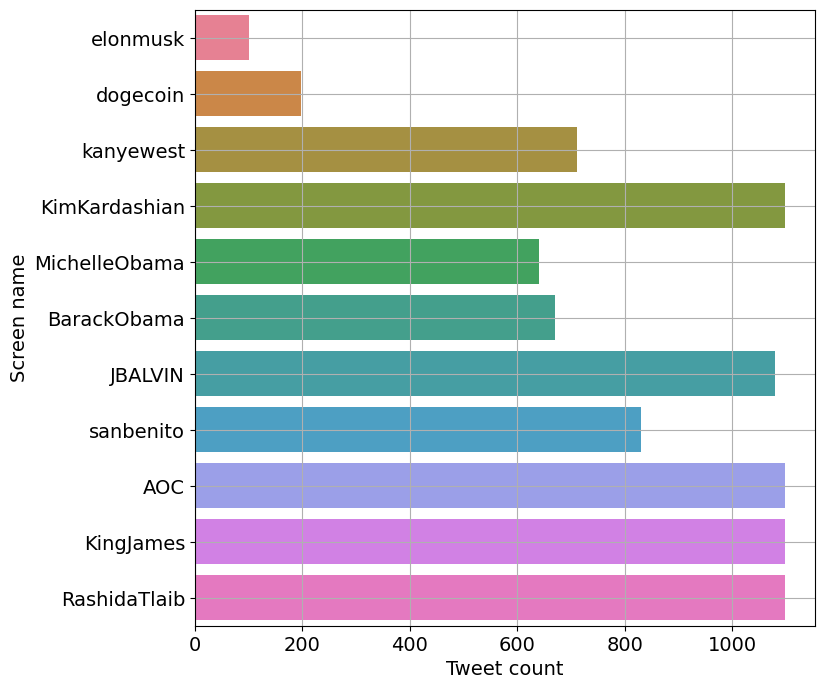

In [92]:
plt.figure(figsize=(8,8))
sns.countplot(data=df, y ='screen_name',
              hue='screen_name',
              palette = "husl")
plt.ylabel("Screen name", fontsize = 14)
plt.xlabel("Tweet count", fontsize = 14)
plt.grid()
plt.show()

### Cleaning Text Data
Next we will clean the tweet text.  We use the `clean_tweet` function in the TextAnalytics module.  This function removes punctuation and hyperlinks, and also makes all the text lower case.  We remove any cleaned tweets which have zero length, as these won't be useful for clustering.  We add a column to `df` called `"text_clean"` with the cleaned tweets.

In [93]:
# prompt: apply text_clean to df['text'] and make it a new column 'text_clean'. then remove all rows in df where len text_clean ==0


df['text_clean'] = df['text'].apply(ta.clean_tweet)  #clean the tweets
df = df[df['text_clean'].str.len() >0]  #remove cleaned tweets of lenght 0

nclean = len(df)

print(f"{n} tweets, {nclean} clean tweets")

df.sample(n=5)

8626 tweets, 8055 clean tweets


,screen_name,text,retweet_count,text_clean
8586,RashidaTlaib,RT @haymarketbooks: From #StopAsianHate to Cro...,44,haymarketbooks from stopasianhate to crossraci...
935,kanyewest,I CAN BEAT BIDEN OFF OF WRITE INS #2020VISION,11964,i can beat biden off of write ins 2020vision
7744,RashidaTlaib,"""The industry is expected to break its lobbyin...",129,the industry is expected to break its lobbying...
7489,KingJames,BANG BANG!! In my *Mike Breen voice,36266,bang bang in my mike breen voice
7678,RashidaTlaib,Their actions are endangering lives and puttin...,46,their actions are endangering lives and puttin...


# Copy of Dataframe

Sometimes you want to work on a slice of a dataframe.  For example, maybe you want to work with a slice that contains tweets from a single screen name.  If you want to add a column to the slice, you will get a warning, because the slice is tied to the original dataframe.  To avoid this, use the `copy` function when creating the slice.  This makes the slice an independent copy and now you can add colummns without any error.

In [17]:
print("Adding a column to a slice of a dataframe (not a copy) gives a warning")

df_aoc = df[df.screen_name=='AOC']

df_aoc['test'] = df.retweet_count


Adding a column to a slice of a dataframe (not a copy) gives a warning


<ipython-input-17-1230cc214e64>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aoc['test'] = df.retweet_count


In [18]:
print("Adding a column to a copy of a slice of a dataframe is ok")

df_aoc = df[df.screen_name=='AOC'].copy()

df_aoc['test'] = df.retweet_count

Adding a column to a copy of a slice of a dataframe is ok


# Word Cloud

We can make a word cloud of the tweets using the `WordCloud` function which takes as input a list of stopwords and many other parameters.

The list of stopwords is `STOPWORDS`.  We apply the `set` function so we can remove duplicates and easily add new words.  To add a new stopword to the set, we use the `add` function.

We convert the `text` column of our dataframe into a single giant string called `text` using the `tolist` and `join` functions.  We then apply the `generate` function to `text` to make the word cloud.  The `imshow` function allows us to visualize the word cloud.



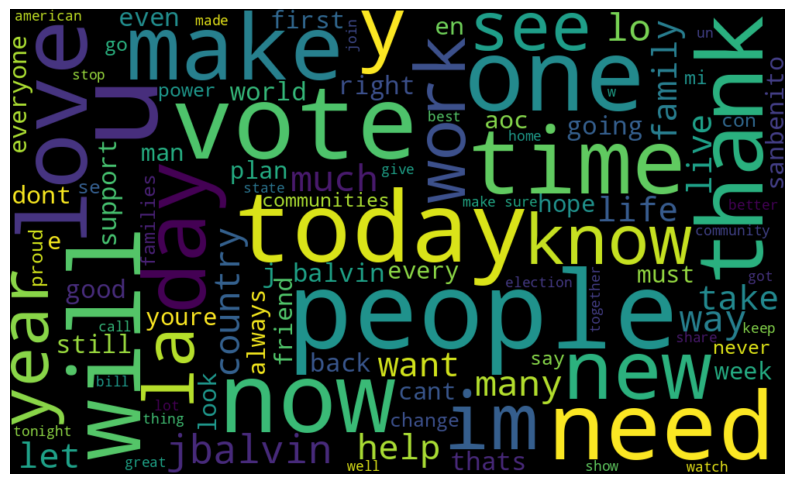

In [20]:
# prompt: make a wordcloud of df['text_clean']
# prompt: to STOPWORDS add Spanish stopwords

stopwords = set(STOPWORDS)
stopwords.update(['de','que','el','la','los','las','un','una','unos','unas','al','del','se','le','les','me','te','nos','os','pero','por','para','con','como','hasta','cuando','donde','quien','quienes','cual','cuales','porque','para','que','quien','quienes','cual','cuales','porque','sobre','tras','entre','sin','durante','antes','después','bajo','sobre','ante','según','contra','luego','menos','mucho','nada','nunca','ni','ningún','ninguna','ningunos','ningunas','otro','otra','otros','otras','poco','pocos','pocas','primero','primera','primeros','primeras','propio','propia','propios','propias','sí','solo','sola','solos','solas','también','tampoco','tan','tanto','tanta','tantos','tantas','toda','todas','todos','total','tras','un','uno','una','unos','unas','vosotros','vosotras','vuestro','vuestra','vuestros','vuestras','y','ya','yo'])


text=' '.join(df['text_clean'].tolist()).lower()
wordcloud = WordCloud(stopwords=stopwords,max_font_size=150,
                      max_words=100,
                      background_color="black",
                      width=1000,
                      height=600)

wordcloud.generate(text)

#visualize word cloud
fig = plt.figure(figsize = (10,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Create Text Embeddings

To cluster the tweets, we need to create vector embeddings for them.  We can do this using vectorizers.  We have two simple options here.  One is as a term frequency (tf) vectorizer called *CountVectorizer*.  The other is a term-frequency inverse document-frequency (tf-idf) vectorizer called *TfidfVectorizer*.


### Term Frequency (TF) Embedding

We initialize the `CountVectorizer` and tell it to remove English stopwords with the `stop_words` parameter set to `"english"`.  We also tell it to remove any word that occur in less than 5 documents with the `min_df` parameter.  Then we use the `fit_transform` method applied to the `text_clean` column of `df` to create the document vectors, which we call `tf_embedding`.  The `fit_transform` function first fits the model (meaning figures out what words are in the vocabulary) and then transforms the text in the TF vectors.

We store the words for each element of the vector in `tf_feature_names`.

In [23]:
# prompt: compute term frequency embedding of df['text_cean']

tf_vectorizer = CountVectorizer(min_df=5, stop_words='english')
tf_embedding = tf_vectorizer.fit_transform(df['text_clean'])
tf_feature_names = tf_vectorizer.get_feature_names_out()

nvocab = len(tf_feature_names)
ntweets = len(df.text_clean)
print(f"{ntweets} tweets, {nvocab} words in vocabulary")
print(f"TF embedding shape is {tf_embedding.shape}")

8055 tweets, 3095 words in vocabulary
TF embedding shape is (8055, 3095)


### Latent Dirichlet Allocation (LDA) Embedding

We will fit an LDA topic model on the tf embedding of the tweets. Much of this section pulls code from this blog:

https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730



#### Fitting LDA Model

To fit an LDA model we need to specify the number of topics.  There are sophisticated ways to do this, but because it takes some time to fit the model, we will cheat here.  We set `num_topics` equal to the number of unique users in the dataset.  Hopefully we find one topic for each user.  To fit the model we use the `LatentDirichletAllocation` function.  We first initialize this object, which we call `lda_model`, with the number of topics, and then use the `fit` function to fit the model to `tf_embedding`.

In [25]:
%%time
num_topics = len(df['screen_name'].unique())
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
lda_model.fit(tf_embedding)

CPU times: user 5.49 s, sys: 36.6 ms, total: 5.52 s
Wall time: 6.68 s


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, random_state=0)

#### Transform Tweets into Topic Embedding Vectors Using LDA Model

Next we convert each tweet into a topic embedding vector.  This vector length is the number of topics in the LDA model.  The value of each element tells us the probability the tweet contains this topic.  The conversion is done using the `transform` function.  The resulting topic vectors are called `lda_embedding`.  We can look at the shape of the embedding using the `shape` parameter.

In [28]:
# prompt: transform tf_embedding in lda embeddings using the fit lda_model

lda_embedding = lda_model.transform(tf_embedding)
print(f"{ntweets} tweets, {num_topics} topics in LDA model")
print(f"shape of lda embedding is {lda_embedding.shape}")

8055 tweets, 11 topics in LDA model
shape of lda embedding is (8055, 11)


#### Visualizing LDA Topics

We will visualize the topics by making barplots of the top weighted words in each topic.

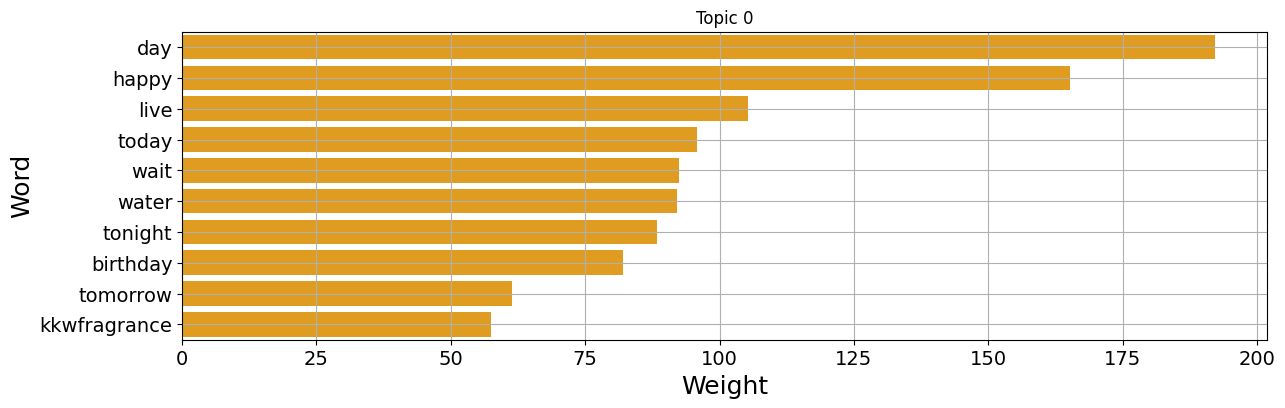

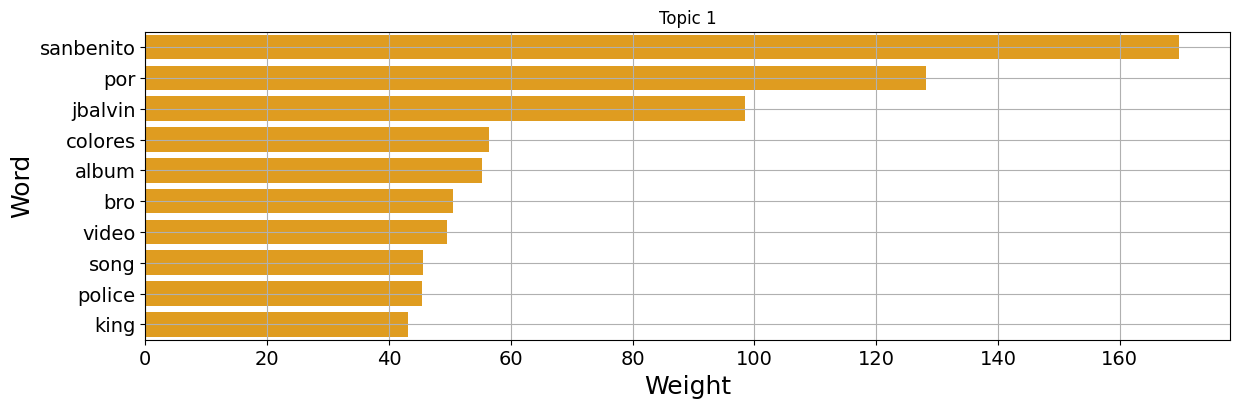

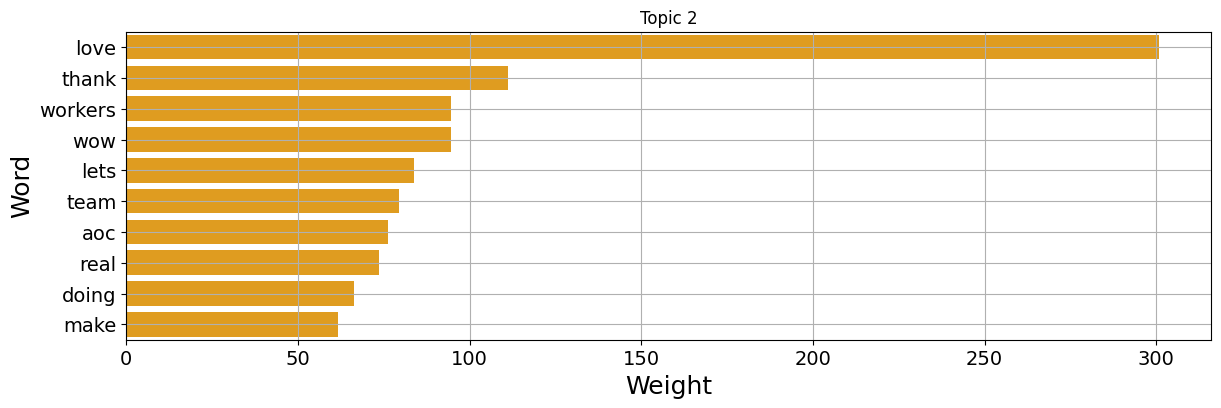

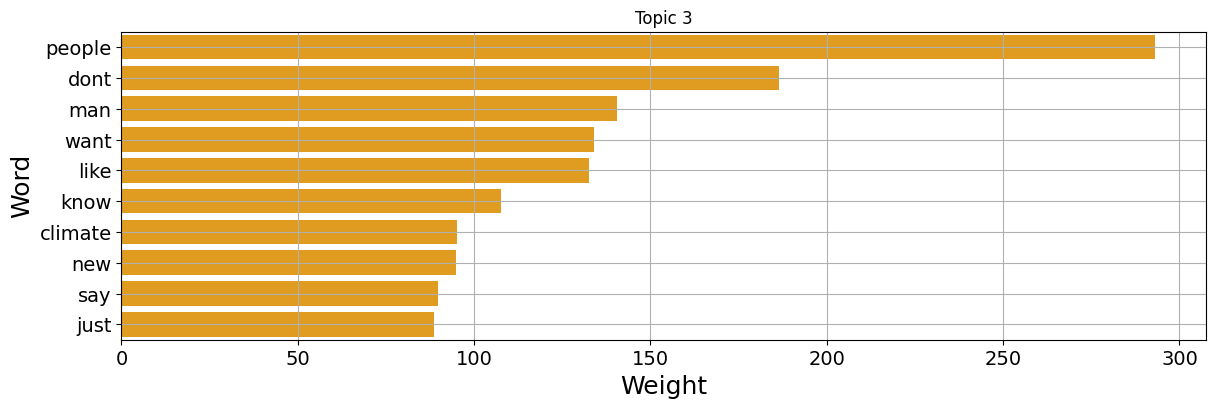

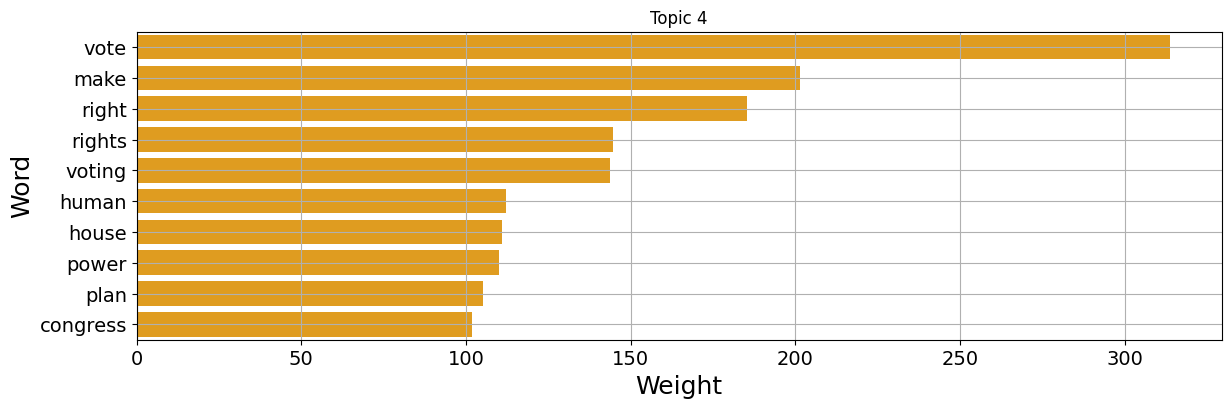

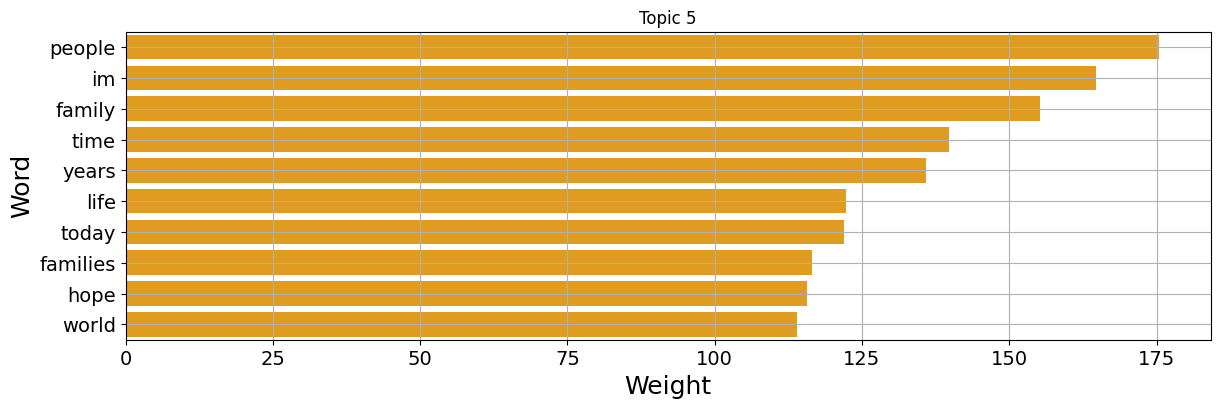

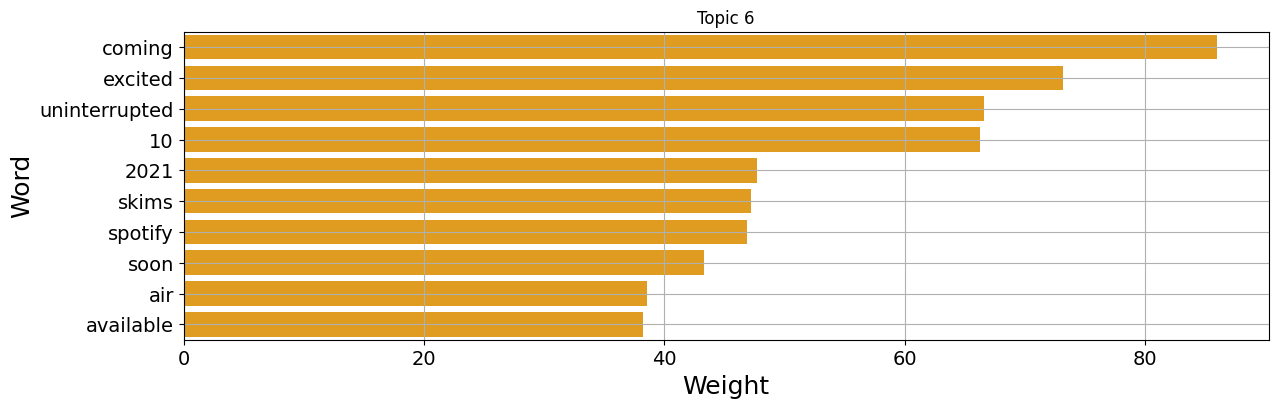

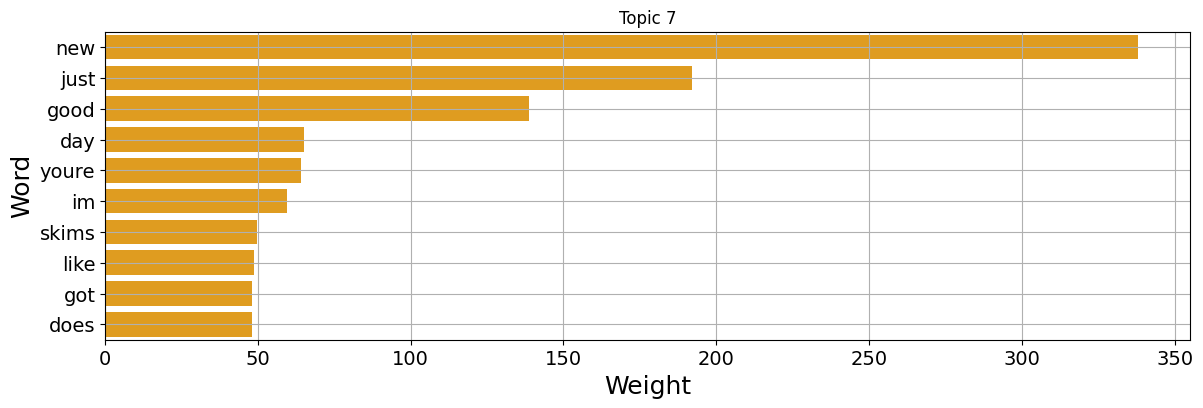

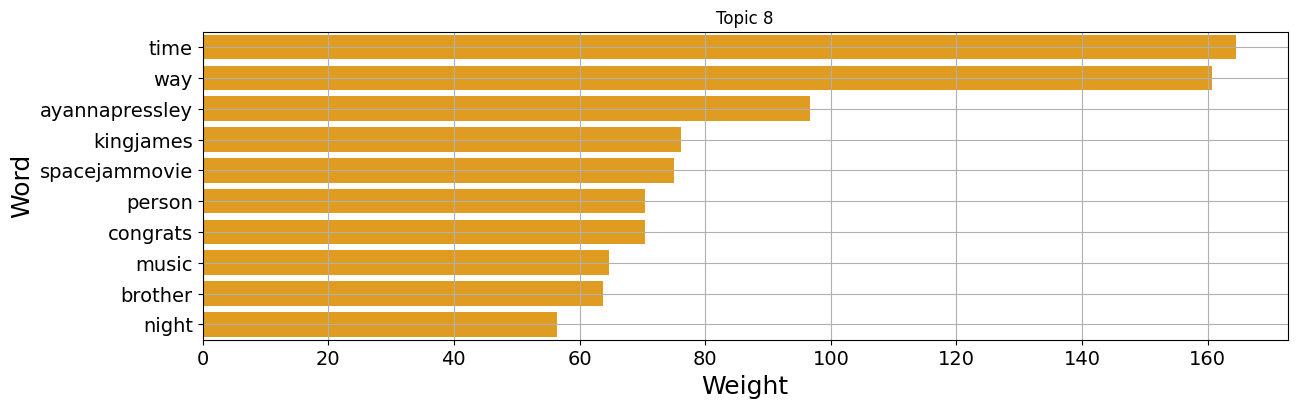

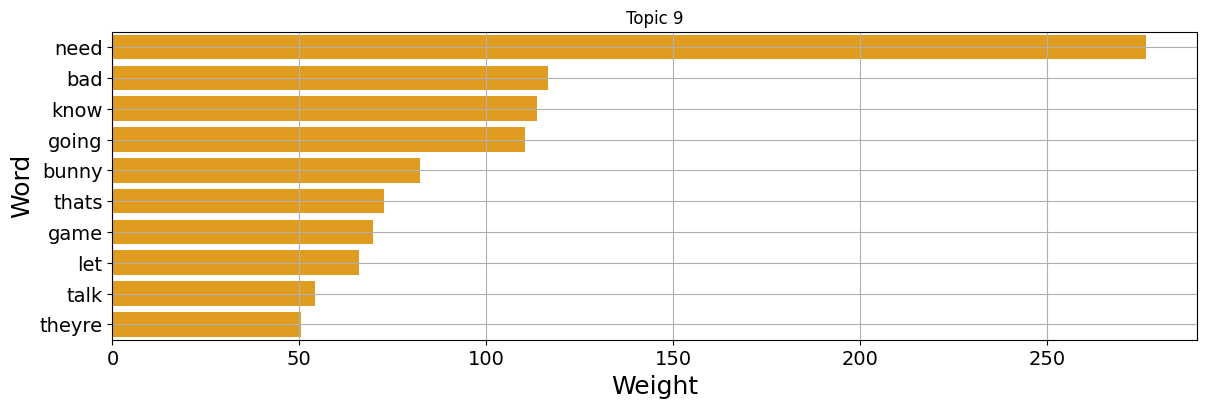

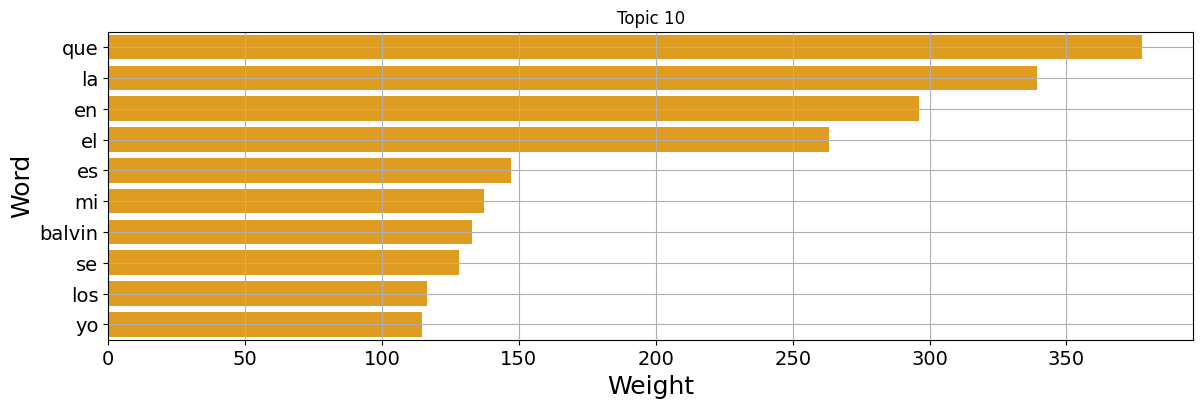

In [34]:
# prompt: make a separate barplot of the top 10 heaviest words for each topic in the fit lda_model.

topic_word_matrix = lda_model.components_

for i in range(num_topics):
  # Get the indices of the top words in descending order
  top_word_indices = np.argsort(topic_word_matrix[i])[-10:][::-1]

  # Get the top words and corresponding weights using the indices
  top_words = tf_feature_names[top_word_indices]
  top_weights = topic_word_matrix[i][top_word_indices]

  # Create a DataFrame for plotting
  df_topic = pd.DataFrame({'Word': top_words, 'Weight': top_weights})

  # Plotting
  plt.figure(figsize=(14, 4))
  sns.barplot(data=df_topic, y='Word', x='Weight', color='orange')
  plt.grid()
  plt.title(f"Topic {i}")
  plt.show()


## Transformer Embedding

We will calculate the transformer embedding of the text using the pre-trained RoBERTa model available on the HuggingFace platform.  To make the computation faster, we will use a GPU for the computation.

### Use a GPU

This code will set the `device` that does the computing to the GPU if you are using it.

In [35]:
# Check if GPU is available and set PyTorch to use the GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


### Load Transformer

We can load the transformer from the HuggingFace website (https://huggingface.co/).  We just need the `model_name` and `tokenizer` (the tokenizer maps each word or token to a vector).  We will use the `"roberta-base"` transformer (https://huggingface.co/roberta-base).

In [36]:
# prompt: # Load the pre-trained roberta-base model and tokenizer
model_name = "roberta-base"  # You can choose the desired RoBERTa model
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaModel.from_pretrained(model_name)

# Move the model to the GPU
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Compute the Transformer Embeddings

Here is where the GPU comes in handy.  This code goes through each tweet, runs it through the transformer, and gets the embedding vector using the `compute_roberta_embedding` function we write.  At the end it makes the embedding vectors into a nice numpy array so later calculations are easy to do.

One nice thing about transformers is that we dont need to clean up the text, the `tokenizer` does it for us.

**Note**: This cell takes about 2 minutes to run with a GPU, and MUCH longer with a CPU.

In [38]:
# prompt: write a function compute_roberta_embedding that takes text as input and returns its embedding vector

def compute_roberta_embedding(text):
    # Tokenize the input text and convert it to a tensor
    input_ids = tokenizer.encode(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    input_ids =input_ids.to(device)

    # Generate embeddings using the RoBERTa model
    with torch.no_grad():
        output = model(input_ids)

    # Extract the embeddings (CLS token) from the output
    embedding = output.last_hidden_state.mean(dim=1).cpu().squeeze().numpy()

    return embedding

In [39]:
%%time
# prompt: write a for loop that goes through each row in df, takes the text, applies compute_roberta_embedding, and saves all the embeddings as one big numpy array transformer_embedding.  print progress every 1000 rows.

transformer_embedding=[]
for index, row in df.iterrows():
  e = compute_roberta_embedding(row.text)
  transformer_embedding.append(e)

  if index%1000==0:  #this prints out our progress every 1000 tweets
    print(f"Row {index}/{len(df)}")

transformer_embedding = np.array(transformer_embedding)
print(f"Shape of embeddings is {transformer_embedding.shape}")

Row 0/8055
Row 1000/8055
Row 2000/8055
Row 3000/8055
Row 4000/8055
Row 5000/8055
Row 6000/8055
Row 7000/8055
Row 8000/8055
Shape of embeddings is (8055, 768)
CPU times: user 1min 43s, sys: 346 ms, total: 1min 43s
Wall time: 2min


# Low Dimensional Embedding

We can lower the dimension of our embeddings down to something we can plot (2 dimensions) using dimensionality reduction algorithms. Also, sometimes the lower dimensional embedding makes better text clusters. We will use 2 dimensionality reduction algorithms here:

1) PCA - very quick, but not the nicest looking

2) t-SNE - slower, but nicer looking

We will discuss PCA and t-SNE in a future lecture.

### PCA Embedding

PCA works sort of like LDA.  We have to create the model, then fit it, and then transform the data with the fit model.  Therefore, we use the `fit_transform` function.

In [43]:
%%time
n_components = 2
pca_tf_embedding = PCA(n_components=n_components, random_state=0).fit_transform(tf_embedding.toarray())

pca_lda_embedding = PCA(n_components=n_components, random_state=0).fit_transform(lda_embedding)



CPU times: user 2.22 s, sys: 474 ms, total: 2.7 s
Wall time: 3.24 s


In [44]:
pca_transformer_embedding = PCA(n_components=n_components, random_state=0).fit_transform(transformer_embedding)


### t-SNE Embedding

t-SNE also works sort of like LDA, but much slower.  We have to create the model, then fit it, and then transform the data with the fit model.  Therefore, we use the `fit_transform` function.

In [48]:
%%time
n_components = 2

#tsne_tf_embedding = TSNE(n_components=n_components).fit_transform(tf_embedding.toarray())
tsne_lda_embedding = TSNE(n_components=n_components).fit_transform(lda_embedding)

CPU times: user 2min 2s, sys: 354 ms, total: 2min 2s
Wall time: 1min 35s


In [49]:
%%time
tsne_transformer_embedding = TSNE(n_components=n_components).fit_transform(transformer_embedding)


CPU times: user 2min 4s, sys: 687 ms, total: 2min 4s
Wall time: 1min 42s


### Add Embeddings to DataFrame

Add all the PCA and t-SNE x and y coordinates for each tweet to `df`.


In [50]:
df['pca_tf_x'] = pca_tf_embedding[:, 0]
df['pca_tf_y'] = pca_tf_embedding[:, 1]

df['pca_lda_x'] = pca_lda_embedding[:, 0]
df['pca_lda_y'] = pca_lda_embedding[:, 1]


df['tsne_lda_x'] = tsne_lda_embedding[:, 0]
df['tsne_lda_y'] = tsne_lda_embedding[:, 1]


In [60]:
df['pca_transformer_x'] = pca_transformer_embedding[:, 0]
df['pca_transformer_y'] = pca_transformer_embedding[:, 1]

df['tsne_transformer_x'] = tsne_transformer_embedding[:, 0]
df['tsne_transformer_y'] = tsne_transformer_embedding[:, 1]

### Visualize Embeddings

We can use `scatterplot` to plot the embeddings using the x-y coordinates for any of you embeddings.  We will color the data points, which are tweets, by the screen name of their creator using the `hue` parameter.  You just need to select `embedding` from the many you have calculated so far (these are also the column names of the x and y coordinates in `df`).

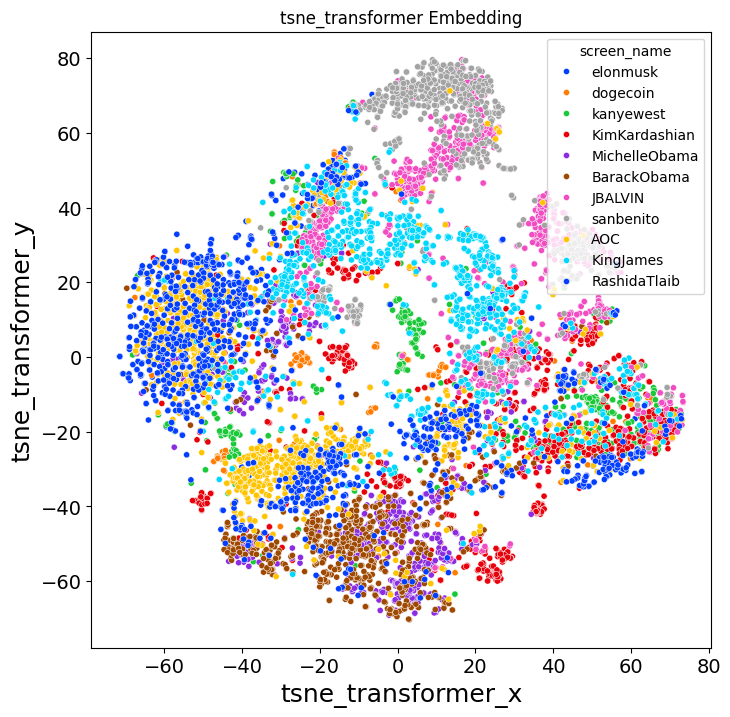

In [63]:
s = 20  #marker size

# embedding can be 'pca_tf', 'pca_lda', 'pca_transformer'
# embedding can be 'tsne_lda', 'tsne_transformer'

embedding = 'tsne_transformer'
colx = f'{embedding}_x'
coly = f'{embedding}_y'
fig = plt.figure(figsize = (8,8))

sns.scatterplot(data=df, x=colx,
                y=coly,
                hue="screen_name",
                s=s,
                palette = 'bright')
plt.title(f"{embedding} Embedding");
plt.show()

# Cluster Tweets Using K-Means on Embeddings

We will cluster the tf, tf-idf, and word2vec embedding vectors using the k-means algorithm.  We choose the number of clusters we want with the variable `n_clusters`.  To get the cluster label of each tweet we initiailize a `KMeans` object with the number of clusters, and then call the `fit_predict` function on the embedding array.  

We create a column in `df` for each k-means cluster label.  

In [64]:
#n_clusters = len(df.screen_name.unique())
n_clusters = 6

kmeans_label = cluster.KMeans(n_clusters=n_clusters).fit_predict(tf_embedding)
df['cluster_tf'] = [str(x) for x in kmeans_label]

kmeans_label = cluster.KMeans(n_clusters=n_clusters).fit_predict(lda_embedding)
df['cluster_lda'] = [str(x) for x in kmeans_label]

kmeans_label = cluster.KMeans(n_clusters=n_clusters).fit_predict(pca_tf_embedding)
df['cluster_pca_tf'] = [str(x) for x in kmeans_label]

kmeans_label = cluster.KMeans(n_clusters=n_clusters).fit_predict(pca_lda_embedding)
df['cluster_pca_lda'] = [str(x) for x in kmeans_label]

kmeans_label = cluster.KMeans(n_clusters=n_clusters).fit_predict(tsne_tf_embedding)
df['cluster_tsne_tf'] = [str(x) for x in kmeans_label]

kmeans_label = cluster.KMeans(n_clusters=n_clusters).fit_predict(tsne_lda_embedding)
df['cluster_tsne_lda'] = [str(x) for x in kmeans_label]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [65]:
kmeans_label = cluster.KMeans(n_clusters=n_clusters).fit_predict(transformer_embedding)
df['cluster_transformer'] = [str(x) for x in kmeans_label]

kmeans_label = cluster.KMeans(n_clusters=n_clusters).fit_predict(pca_transformer_embedding)
df['cluster_pca_transformer'] = [str(x) for x in kmeans_label]

kmeans_label = cluster.KMeans(n_clusters=n_clusters).fit_predict(tsne_transformer_embedding)
df['cluster_tsne_transformer'] = [str(x) for x in kmeans_label]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Plot Embeddings with Cluster Labels

We can make a scatterplot of the tweet embeddings, but this time color the data points using the cluster label.

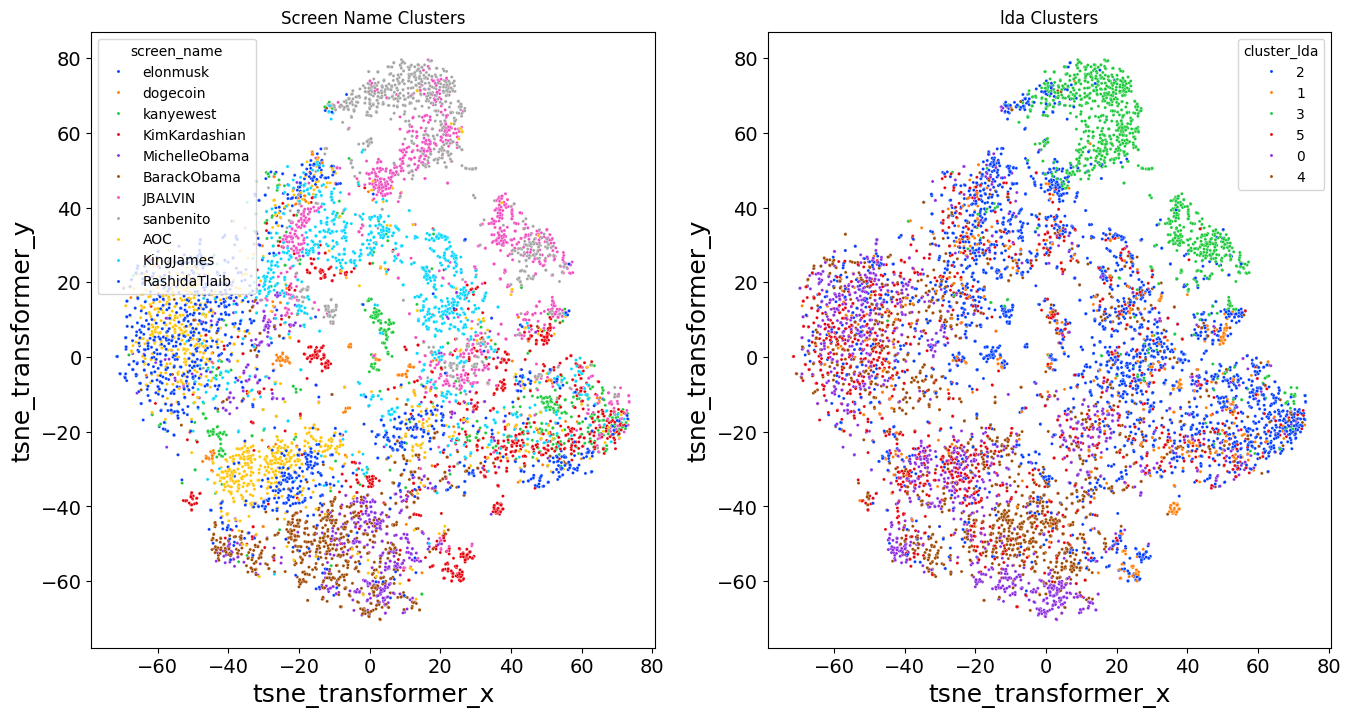

In [73]:
s = 5
embedding_plot = 'tsne_transformer' #the embedding for the x and y coordinates
embedding_hue = 'lda'  #the embedding for the color

colx = f'{embedding_plot}_x'
coly = f'{embedding_plot}_y'
cluster_label = f"cluster_{embedding_hue}"

plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
sns.scatterplot(data=df, x=colx,
                  y=coly,
                  hue="screen_name",
                s=s,
                palette = 'bright')
plt.title("Screen Name Clusters")


plt.subplot(1,2,2)
sns.scatterplot(data=df, x=colx,
                  y=coly,
                  hue=cluster_label,
                s=s,
                palette = 'bright')
plt.title(f"{embedding_hue} Clusters");
plt.show()

## Histograms of Users and Word Clouds of Tweets in the Clusters

We will take the tweets in each cluster, make a word cloud for them, and a histogram of the screen names of the users who posted the tweets.  If we have good clusters, we expect one user to dominate each cluster, or a group of users who use tweet about similar topics.

We will be creating word clouds and histograms again later on, so lets write a function to do it.  The function is called `kmeans_wordcloud_userhist`.  Its inputs are the dataframe with the tweets and cluster labels, `df`, the name of the column with the cluster labels `cluster_label`, and a set of stopwords called `stopwords`.  

In [82]:
def kmeans_wordcloud_userhist(df, cluster_label, stopwords):
    for k in np.sort(df[cluster_label].unique()):
        s=df[df[cluster_label]==k]
        text=' '.join(s.text_clean.tolist()).lower()
        wordcloud = WordCloud(stopwords=stopwords,
                              max_font_size=150,
                              max_words=100,
                              background_color="white",
                              width=1000, height=600)
        wordcloud.generate(text)

        print(f"\n\tCluster {k} {cluster_label} has {len(s)} tweets")
        plt.figure(figsize = (16,4))
        plt.subplot(1,2,1)
        ax = sns.countplot(data = s, y = 'screen_name', hue = 'screen_name')
        plt.grid()
        plt.xlabel("Number of tweets")
        plt.ylabel("Screen name")
        plt.title(cluster_label)
        plt.subplot(1,2,2)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    return 1


	Cluster 0 cluster_tsne_transformer has 1244 tweets


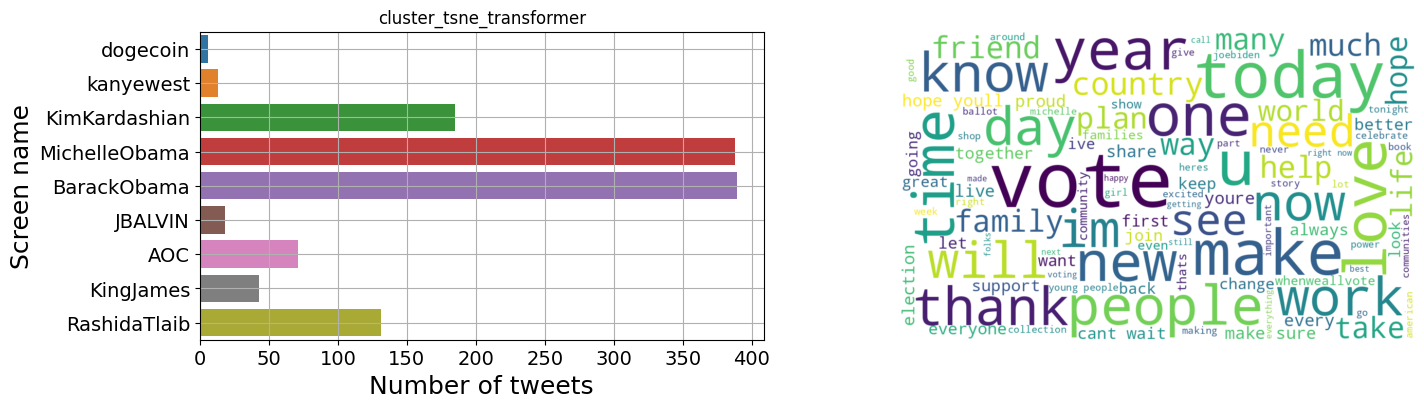


	Cluster 1 cluster_tsne_transformer has 1456 tweets


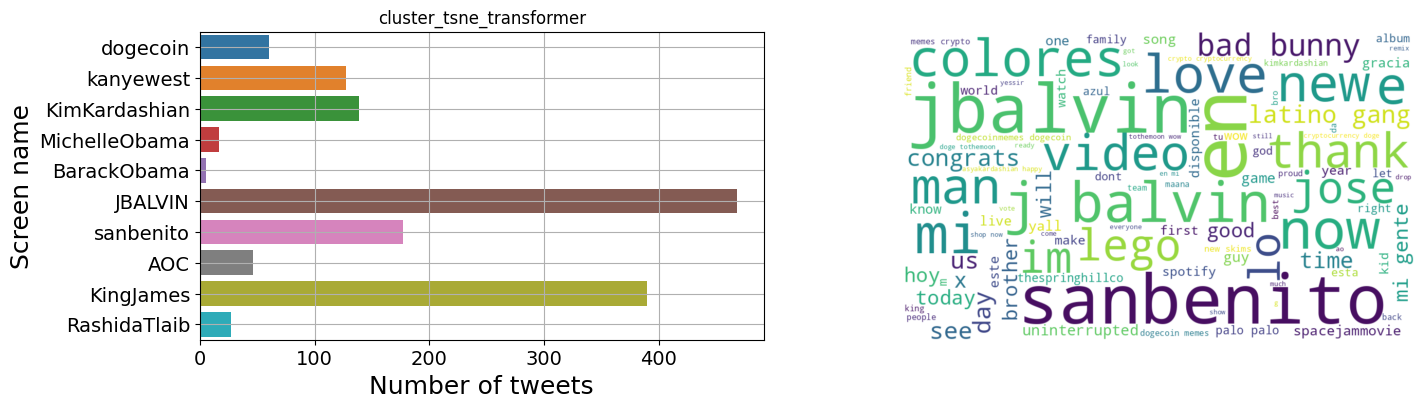


	Cluster 2 cluster_tsne_transformer has 1776 tweets


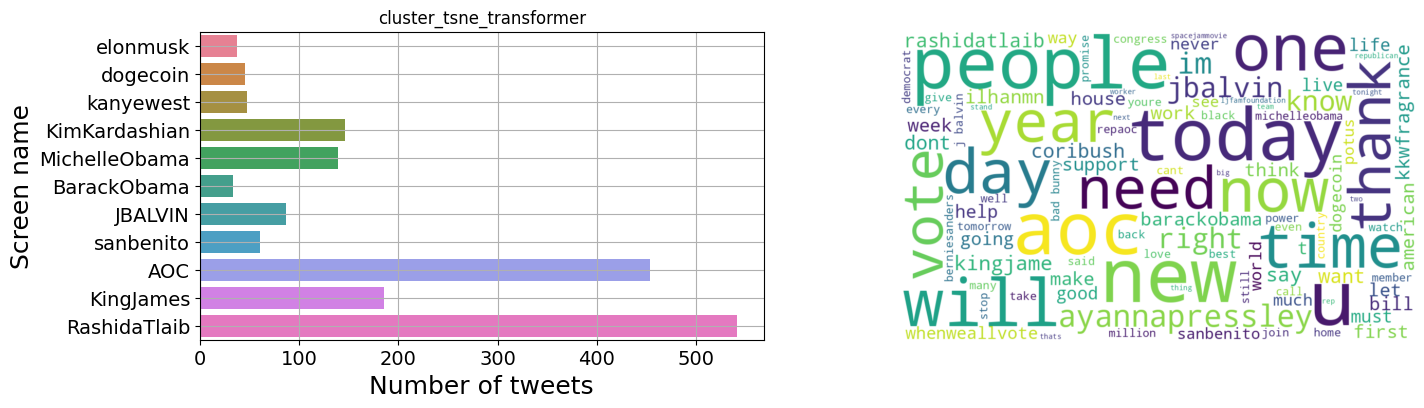


	Cluster 3 cluster_tsne_transformer has 1064 tweets


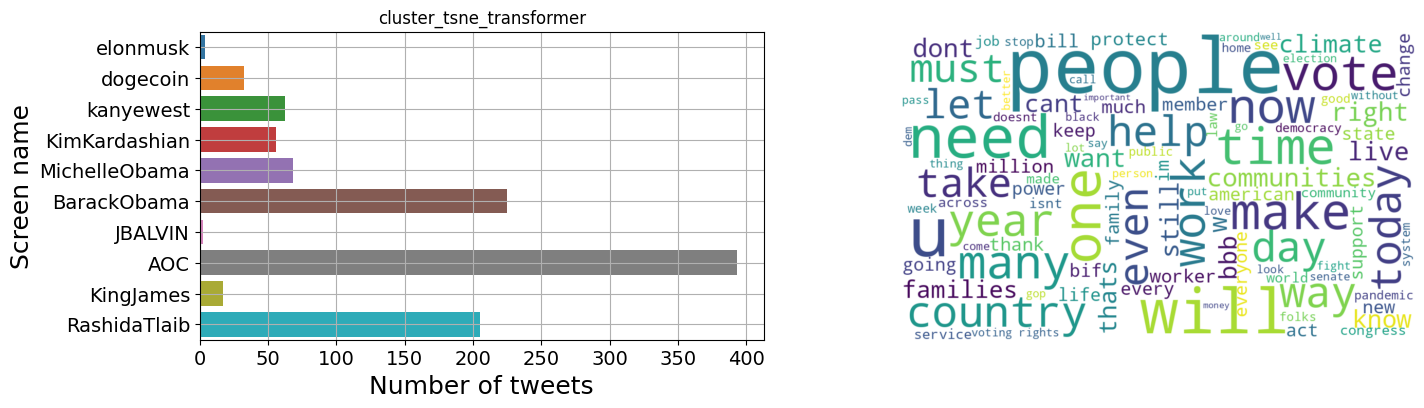


	Cluster 4 cluster_tsne_transformer has 1426 tweets


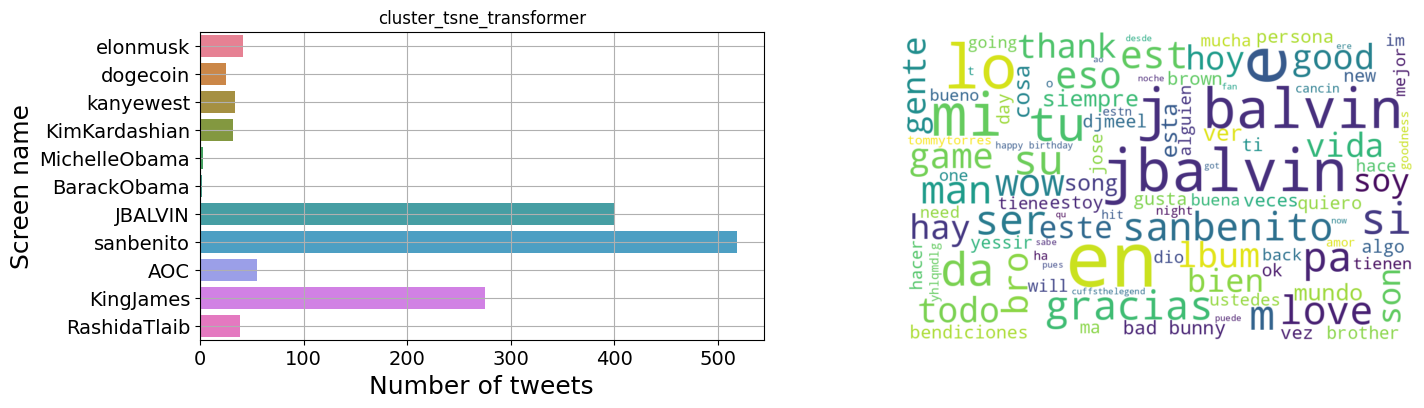


	Cluster 5 cluster_tsne_transformer has 1089 tweets


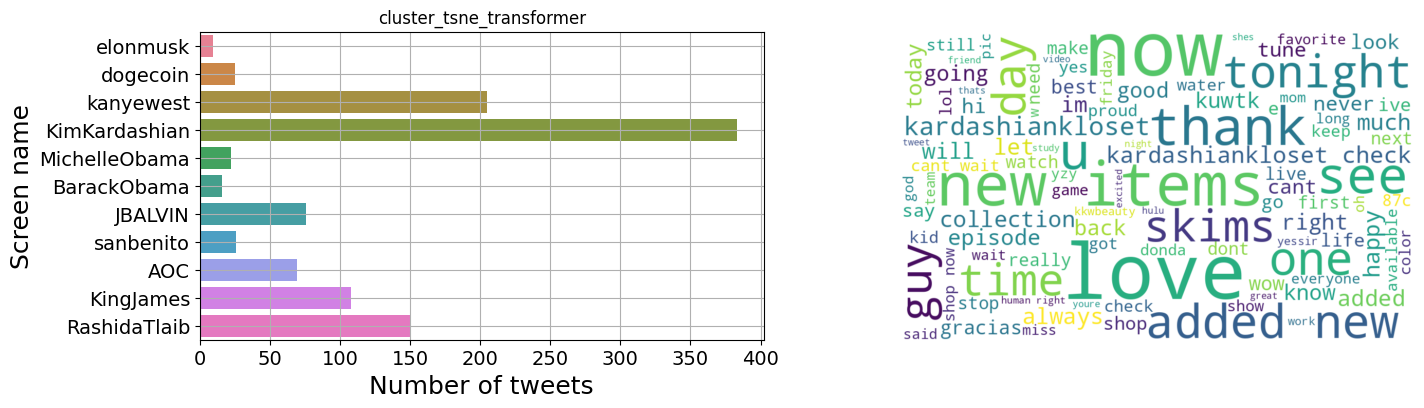

1

In [84]:
# prompt: to STOPWORDS add spanish stopwords

stopwords = set(STOPWORDS)
stopwords.update(['de','que','el','la','los','las','un','una','unos','unas','al','del','se','le','les','me','te','nos','os','pero','por','para','con','como','hasta','cuando','donde','quien','quienes','cual','cuales','porque','para','que','quien','quienes','cual','cuales','porque','sobre','tras','entre','sin','durante','antes','después','bajo','sobre','ante','según','contra','luego','menos','mucho','nada','nunca','ni','ningún','ninguna','ningunos','ningunas','otro','otra','otros','otras','poco','pocos','pocas','primero','primera','primeros','primeras','propio','propia','propios','propias','sí','solo','sola','solos','solas','también','tampoco','tan','tanto','tanta','tantos','tantas','toda','todas','todos','total','tras','un','uno','una','unos','unas','vosotros','vosotras','vuestro','vuestra','vuestros','vuestras','y','ya','yo'])

embedding_hue = 'tsne_transformer'  #the embedding for the color
cluster_label = f"cluster_{embedding_hue}"

kmeans_wordcloud_userhist(df,cluster_label,stopwords )